In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import datetime as dt
import json

# Preliminary Data

Used to create data cleaning function

In [3]:
def organize_twitch_chat(json_name):
    data = pd.read_json(json_name, orient='records')
    df = data[['created_at','updated_at','commenter','message']]
    messages = df['message'].apply(pd.Series).drop(['fragments','user_color','user_notice_params'],axis=1)
    users = df['commenter'].apply(pd.Series)
    
    df = df.drop(['message','commenter'], axis=1) # duplicate info
    df = pd.concat([df,users,messages],axis=1)
    df = df.iloc[:,[0,1,2,3,4,5,6,9,10,11,12,13]] # select cols that arent duplicates
    
    return df

In [4]:
df = organize_twitch_chat("sample_data.json")

In [5]:
df['time_clipped'] = df['created_at'].astype(str).str.extract('(\d\d\d\d-\d\d-\d\d \d\d:\d\d)')

In [6]:
df.groupby('display_name').count().sort_values('body')

,created_at,updated_at,_id,name,type,bio,logo,body,is_action,user_badges,emoticons,time_clipped
display_name,,,,,,,,,,,,
mdsvellhoo,1,1,1,1,1,0,1,1,1,0,0,1
chicken2013,1,1,1,1,1,0,1,1,1,0,0,1
luuser830,1,1,1,1,1,0,1,1,1,1,0,1
Pekoeta,1,1,1,1,1,0,1,1,1,1,1,1
littleballofhate,1,1,1,1,1,0,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
stevekay4444,20,20,20,20,20,0,20,20,20,20,1,20
CptnJLPicard,22,22,22,22,22,0,22,22,22,0,0,22
ninaisnoob,37,37,37,37,37,37,37,37,37,37,10,37


Text(0.5, 1.0, 'Messages per User')

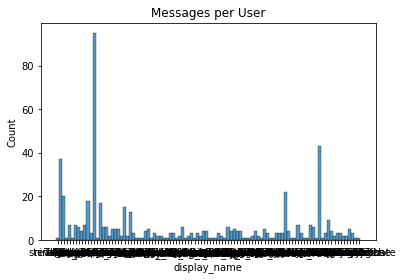

In [7]:
sns.histplot(df['display_name'])
plt.title('Messages per User')

# Big Data

[Twitch Source](https://www.twitch.tv/videos/955629991)

In [8]:
big_df = organize_twitch_chat("big_data.json") # fetch appropriate data

Text(0.5, 1.0, 'Message Count')

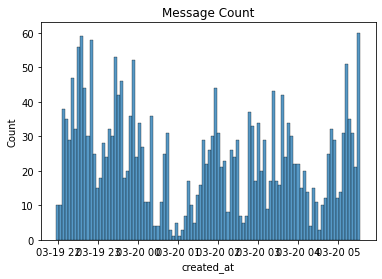

In [9]:
sns.histplot(big_df['created_at'], bins=100)
plt.title("Message Count")

Text(0.5, 1.0, 'Messages per User')

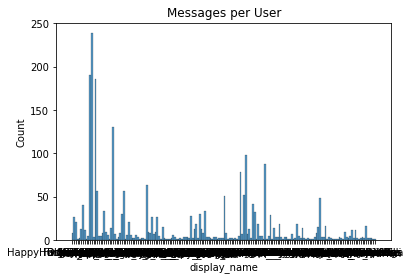

In [10]:
sns.histplot(big_df['display_name'])
plt.title("Messages per User")

## User Stats

In [11]:
def user_stats(dataframe):
    '''
    Returns the user who sent the most messages, most emoticons, and who changed their username the most
    '''
    temp_df = dataframe.groupby("name").count().reset_index()
    temp_df['username_chg'] = temp_df['_id'] - temp_df['display_name'] # if mismatch in count, then its probs changed username
    
    stats = {}
    for col in ['_id','emoticons', 'username_chg']:
        sort = temp_df.sort_values(col, ascending=False)[['name',col]].iloc[0]
        stat = sort[col]
        _id = sort['name']
        
        if col == '_id':
            col = 'num_messages'
        stats[col] = [_id, stat]
    
    return stats

In [12]:
user_stats(big_df)

{'num_messages': ['dominickstarcraft', 239],
 'emoticons': ['gassyvegan247', 27],
 'username_chg': ['21up21', 0]}

# Algorithm 1: percent user participation

__Description__: Try to find the best moments in clips based on where the most users participated
1. ~~Isolate chat transcript to 1 hour long sessions~~ DONE `dfSplitter`
1. ~~Find total number of unique users that participated in session~~ DONE
1. ~~Find % of users that participated at any given `2 minute` timestamp~~
1. ~~Isolate `top 3` timestamps per session~~

## Split into hour sections

In [48]:
class dfSplitter():
    def __init__(self, dataframe):
        '''
        Splits dataframe into multiple dataframes, each 1 hour long

        output:
        ------
        my_list: list
            List of dataframes
        '''
        # init function finds the first split
        dataframe = dataframe.sort_values("created_at")
        first = dataframe[dataframe['created_at'] <= dataframe.loc[0,'created_at'] + pd.Timedelta(hours = 1)]
        
        self.last_i = first.index.max()
        self.dataframe = dataframe
        self.result = []
        self.result.append(dataframe.iloc[0, 0]) # NOTE: assumes first col is always "created_at" col
        self.result.append(first)
        
    def find_rest(self):
        '''
        Uses last index of first split to find the others
        '''
        dataframe = self.dataframe
        last_i = self.last_i
        if last_i+1 != len(dataframe):
            new_df = dataframe.loc[last_i+1:,:] # clip df to start at last_i
            newest = new_df[new_df['created_at'] <= new_df.loc[last_i+1,'created_at'] + pd.Timedelta(hours=1)] # filter by hour
            self.result.append(newest) # store in list
            self.last_i = newest.index.max()
            
            self.find_rest() # repeat
        else:
            return dataframe # never actually used

In [49]:
def sanity_time_check(dataframe):
    '''
    Checks the time length of dataframe
    '''
    return dataframe['created_at'].max() - dataframe['created_at'].min()

def sanity_list_checker(list1):
    '''
    Prints out detailed information for each item in the list
    '''
    for data in list1:
        print(f"Hour {data['hour_section'].unique()} length: {sanity_time_check(data)}")

## Split each section into 2 minute chunks

In [50]:
class fminChats():
    def __init__(self,dataframe, big_unique, min_= 2):
        '''
        Finds the percent unique chatters that chatted every min_ minutes
        
        input
        -----
        dataframe: pd.DataFrame
            Twitch chat dataframe organized and split by dfSplitter
        big_unique: int
            Total number of unique chatters for the entire Twitch stream
        min_: int
            Minute range to find timestamps for. Ex: Find 2 min long timestamps.
        '''
        
        # init function finds the first split
        dataframe = dataframe.sort_values("created_at")
        first = dataframe[dataframe['created_at'] <= dataframe.iloc[0,0] + pd.Timedelta(minutes = min_)]
        
        self.min_ = min_
        self.total_uniques = len(dataframe['_id'].unique())
        self.big_unique = big_unique
        
        self.last_i = first.index.max()
        self.dataframe = dataframe
        
        self.result = []
        self.result.append(first)
        
    def find_rest(self):
        '''
        Uses last index of first split to find the others
        '''
        dataframe = self.dataframe
        last_i = self.last_i
        if last_i+1 < dataframe.index.max(): # NOT len(dataframe), that bugs out and i dont wanna explain why
            new_df = dataframe.loc[last_i+1:,:] # clip df to start new min_min calc at last_i+1
            newest = new_df[new_df['created_at'] <= new_df.loc[last_i+1,'created_at'] + pd.Timedelta(value=self.min_, unit='minutes')] # filter by minute
            self.result.append(newest) # store in list
            
            self.last_i = newest.index.max()
            self.find_rest() # repeat
        else:
            x=''
    
    def perc_uniques(self, chunk_list):
        '''
        Finds the percent unique chatters for eachd dataframe in the list. Dataframes assumed to be split using self.find_rest.
        '''
        
        perc_unique = {
                f'{self.min_}min_chunk':[],
                'start':[],
                'end':[],
                'num_unique':[],
                'perc_rel_unique':[],
                'perc_abs_unique':[]
        }
        
        
        for i in range(len(chunk_list)):
            # calcuate
            chunk = i
            unique = len(chunk_list[i]['_id'].unique())
            timestamp = [chunk_list[i]['created_at'].min(), chunk_list[i]['created_at'].max()]
            perc_rel = unique/self.total_uniques # this is the total uniques in THAT DATAFRAME, ie the hourly cut
            perc_abs = unique/self.big_unique # this is the total uniques in the entire twitch session
            # store
            perc_unique[f'{self.min_}min_chunk'].append(chunk)
            perc_unique['start'].append(timestamp[0])
            perc_unique['end'].append(timestamp[1])
            perc_unique['num_unique'].append(unique)
            perc_unique['perc_rel_unique'].append(perc_rel)
            perc_unique['perc_abs_unique'].append(perc_abs)
            
        df_unique = pd.DataFrame(perc_unique)
        df_unique['elapsed'] = df_unique['end'] - df_unique['start']
        return df_unique
    

The above class will do everything for one df. The following functions will tie both classes together and format the results.

In [91]:
def results_jsonified(results, vid_id, first_sec):
    '''
    Extracts relevant results and makes them machine readable
    
    input
    -----
    results: pd.DataFrame
        DataFrame with at least start, end columns.
    vid_id: int
        Twitch id of video
    '''
    results['first_sec'] = first_sec # to calculate elapsed time from first sec, in seconds
    results = results.sort_values('perc_rel_unique', ascending=False) # so json format is returned with top result being the most relevant
    json_results = []
    for i, row in results.iterrows():
        og = row['first_sec']
        start = row['start']
        end = row['end']
        
        start_sec = dt.timedelta.total_seconds(start-og) # find difference between first sec and given timestamp, convert that to seconds
        end_sec = dt.timedelta.total_seconds(end-og)
        
        dict_ = {"startTime":start_sec,
                 "endTime":end_sec,
                 "videoId":vid_id}
        json_results.append(dict_)
        
    return json_results
        
def hour_iterator(big_df, vid_id, min_=2):
    '''
    Pushes all dfs in a list through the fminChats function, returns a dataframe of results
    
    input
    -----
    big_df: pd.DataFrame
        Df of the entire twitch session. This is the one that was split by dfSplitter class
    min_: int
        How long a timestamp range should be
    vid_id: int
        Twitch id of video. Needed for jsonify function
    '''
    ds = dfSplitter(big_df) # initiate
    ds.find_rest() # split big_df into 1 hour long separate dfs
    hour_list = ds.result # result stored in class var. NOTE: index 0 is always the very first timestamp of big_df
    first_sec = hour_list[0]
    hour_list = hour_list[1:]

    # initiate empty results df
    results = pd.DataFrame(columns=['hour', f'{min_}min_chunk', 'start', 'end', 'num_unique', 'perc_rel_unique', 'perc_abs_unique'])
    max_uniques = len(big_df['_id'].unique()) # the total number of unique chatters for the entire twitch session

    # iterate all sections through the class
    for i in range(len(hour_list)):
        fm = fminChats(hour_list[i], max_uniques)
        _n = fm.find_rest() # _n not needed
        chunk_list = fm.result # get back list of dfs, each 2 minutes long

        hr_uniques = fm.perc_uniques(chunk_list)
        hr_uniques['hour'] = i + 1
        results = results.append(hr_uniques)

    results['elapsed'] = results['end'] - results['start'] # to double check length
    pretty_results = results.reset_index(drop=True) # prettify
    
    json_results = results_jsonified(results, vid_id, first_sec) # ordered by top perc_rel_unique
    
    return pretty_results, json_results

In [92]:
results, json_results = hour_iterator(big_df, vid_id=955629991)

In [109]:
def save_json(json_results):
    '''
    Saves json_results in txt file.
    '''
    str_  = '['
    for dict_ in json_results:
        str_ += str(dict_) + ', \n '
    str_ += ']'
    
    with open("results.txt",'w') as f:
        f.write(str_)

## Results Top five moments

In [89]:
# for normal people
results.sort_values('perc_abs_unique',ascending=False).head()

,hour,2min_chunk,start,end,num_unique,perc_rel_unique,perc_abs_unique,elapsed
196,8,16,2021-03-20 05:32:08.108000+00:00,2021-03-20 05:33:48.767000+00:00,18,0.545455,0.104651,0 days 00:01:40.659000
129,6,0,2021-03-20 02:57:53.904000+00:00,2021-03-20 02:59:51.806000+00:00,15,0.319149,0.087209,0 days 00:01:57.902000
147,6,18,2021-03-20 03:38:02.837000+00:00,2021-03-20 03:40:01.726000+00:00,15,0.319149,0.087209,0 days 00:01:58.889000
123,5,19,2021-03-20 02:44:47.050000+00:00,2021-03-20 02:46:44.245000+00:00,14,0.274510,0.081395,0 days 00:01:57.195000
114,5,10,2021-03-20 02:19:59.386000+00:00,2021-03-20 02:21:58.812000+00:00,14,0.274510,0.081395,0 days 00:01:59.426000


[Twitch Source](https://www.twitch.tv/videos/955629991)

Variables:
* `hour`: section of twitch chat df, after df was split into 1 hour sections
* `xmin_chunk`: chunk of hour section, after section was split into x min chunks
* `start`: starting timestamp of chunk
* `end`: ending timestamp of chunk
* `num_unique`: number of unique chatters in that chunk
* `perc_rel_unique`: percent of unique __hour section__ chatters participating in that chunk
* `perc_abs_unique`: percent of unique __twitch df__ chatters participating in that chunk

__Conclusion__: The max relative chat engagement was around 55% in the eighth hour of twitch chat during chunk_16. Timestamps `03-20 05:32` to `03-20 05:33` are good candidates

In [93]:
# for engineers
json_results[:8]

[{'startTime': 27319.612, 'endTime': 27420.271, 'videoId': 955629991},
 {'startTime': 26689.814, 'endTime': 26808.451, 'videoId': 955629991},
 {'startTime': 18065.408, 'endTime': 18183.31, 'videoId': 955629991},
 {'startTime': 20474.341, 'endTime': 20593.23, 'videoId': 955629991},
 {'startTime': 3152.329, 'endTime': 3271.822, 'videoId': 955629991},
 {'startTime': 26320.325, 'endTime': 26439.613, 'videoId': 955629991},
 {'startTime': 8672.863, 'endTime': 8759.628, 'videoId': 955629991},
 {'startTime': 6851.107, 'endTime': 6965.998, 'videoId': 955629991}]

In [107]:
save_json(json_results) # save as txt file

## Graphs

/Users/peter/opt/miniconda3/envs/data_env/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 1.05, 'Percent chatters, relative to each hour')

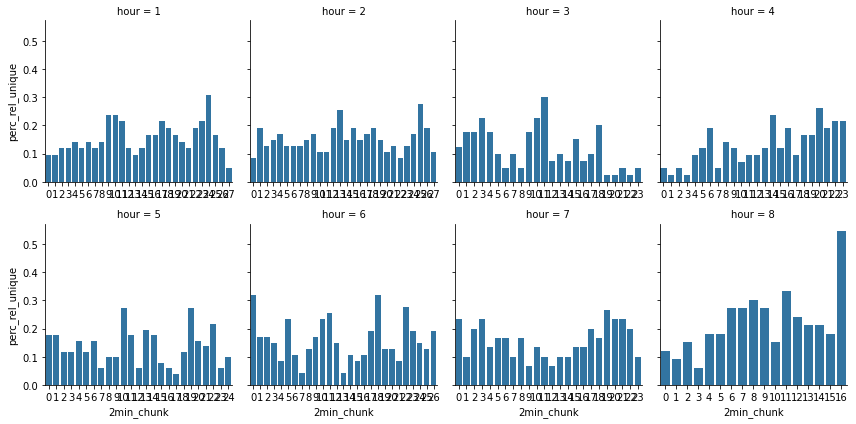

In [21]:
g = sns.FacetGrid(results,col='hour',sharex=False, col_wrap = 4)
g.map(sns.barplot,'2min_chunk','perc_rel_unique')

plt.suptitle("Percent chatters, relative to each hour",y=1.05)

/Users/peter/opt/miniconda3/envs/data_env/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 1.05, 'Percent of twitch session chatters participating at each chunk')

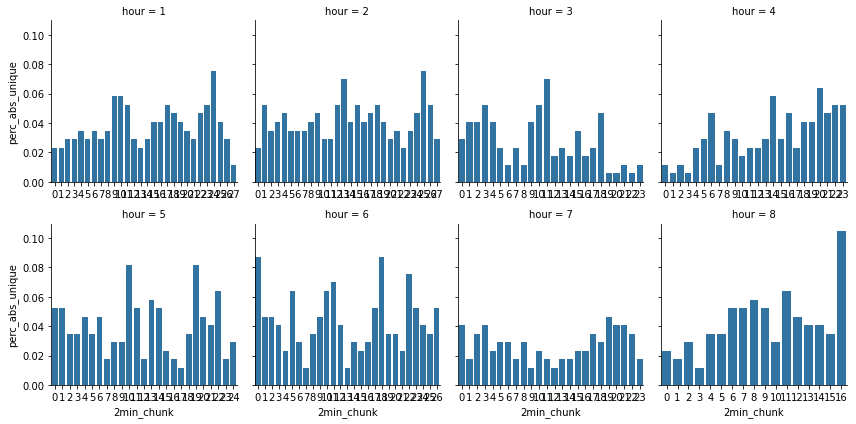

In [22]:
g = sns.FacetGrid(results,col='hour',sharex=False, col_wrap = 4)
g.map(sns.barplot,'2min_chunk','perc_abs_unique')

plt.suptitle("Percent of twitch session chatters participating at each chunk",y=1.05)

### BUG

Why do the perc_abs_unique and perc_rel_unique have the same exact graphs???

# Algorithm 2: percent user activity

__Description__: Try to find the best moments in clips based on when rate of messages per user peaked

1. ~~Isolate chat transcript to 1 hour long sessions~~ DONE
1. Find overall message rate per 2 minutes per users
1. Identify timestamps where `message_rate` peaked

Based on the above, it looks like top message sender sent the top message at all hours